# Aquaplanet Theory
This looks at extending the aquaplanet theory to land.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-10-31 15:44:03,560 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
p_surface = float(ds[0].pfull) * 100

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

There will be on dataset for all ocean coordinates, `ds_all['ocean']` and one for all land coordinates, `ds_all['land']`.

In [3]:
# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

### Show where Land is
The land is a meridional band, between the latitudes indicated below.

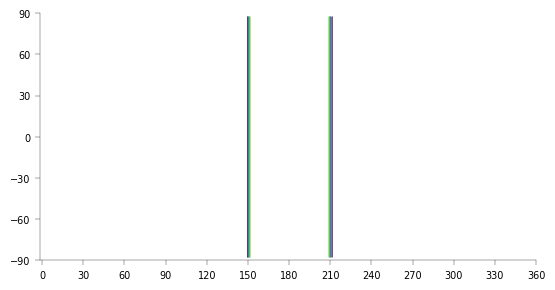

In [4]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

In [5]:
# Load in across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = {'ocean': [], 'land':[]}
lon = {}
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_use = ds_use.load()
        for surf in ds_all:
            ds_all[surf] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            pbar.update(1)

100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all['ocean'][0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all['ocean'][0].lat))     # latitude area weighting is just the cosine

temp_mean = {surf: np.zeros((n_exp, n_lat)) for surf in ds_all}
sphum_mean = {surf: np.zeros((n_exp, n_lat)) for surf in ds_all}
mse_mean = {surf: np.zeros((n_exp, n_lat)) for surf in ds_all}
r_mean = {surf: np.zeros((n_exp, n_lat)) for surf in ds_all}

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = {surf: np.zeros((n_exp, n_lat, n_quant)) for surf in ds_all}
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = {surf: np.zeros((n_exp, n_lat, n_quant)) for surf in ds_all}
# mse as function of mse quantile not temp quantile
mse_quant2 = {surf: np.zeros((n_exp, n_lat, n_quant)) for surf in ds_all}

with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in ds_all:
            ds_use = ds_all[surf][i]
            temp_mean[surf][i] = ds_use.temp.mean(dim='lon_time')
            sphum_mean[surf][i] = ds_use.sphum.mean(dim='lon_time')
            mse_mean[surf][i] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).mean(dim='lon_time')
            r_mean[surf][i] = 100 * (ds_use.sphum/sphum_sat(ds_use.temp, p_surface)).mean(dim='lon_time')
        
            temp_quant2[surf][i] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            sphum_quant2[surf][i] = ds_use.sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
            mse_quant2[surf][i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            pbar.update(1)

100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


## Aquaplanet version of the theory
The starting approximation for this theory is $\delta h(x_h) \approx \delta \overline{h}$, where $x_h$ is moist static energy percentile.

### Percentile to Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, but for ocean and land separately.

This shows that the scaling, $\lambda(x) = \frac{\delta h(x)}{\delta \overline{h}}$, is very close to 1 for all percentiles, $x$ over ocean. Over land, the approximation is less valid, with $\lambda(x)$ increasing with $x$.

In [7]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'midlat'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'highlat'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use = np.where((np.abs(ds_all['ocean'][0].lat) <= lat_max) & (np.abs(ds_all['ocean'][0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

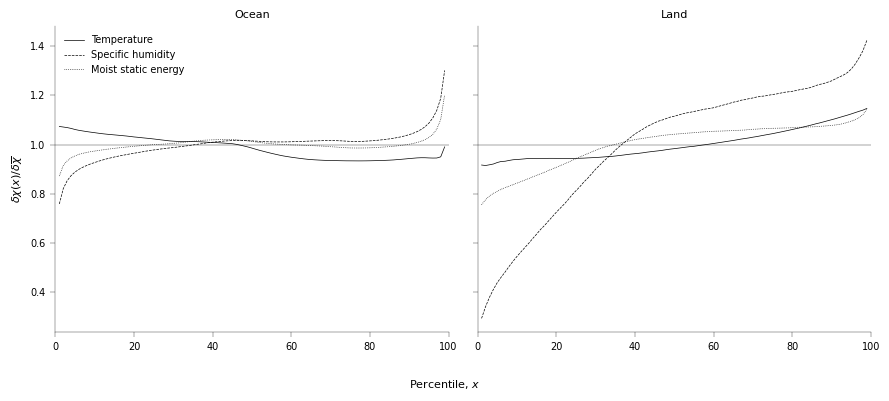

In [8]:
save_lambda_fig = False
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
labels = ['Temperature','Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = {surf: [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean[surf], sphum_mean[surf], mse_mean[surf]]] for surf in ds_all}
linestyles = ['-', '--', ':']
for j, surf in enumerate(ds_all):
    ax[j].set_title(surf.capitalize())
    for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
        var_ratio = (var[surf][1]-var[surf][0])/delta_var_mean[surf][i]
        ax[j].plot(quant_plot, np.average(var_ratio[lat_use], axis=0, weights=lat_weights_use), label=labels[i], color='k', linestyle=linestyles[i])
delta_mse_ratio = {surf: (mse_quant2[surf][1]-mse_quant2[surf][0])/delta_var_mean[surf][-1] for surf in ds_all}
ax[0].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[1].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[0].legend()
fig.supxlabel('Percentile, $x$', fontsize=8)
ax[0].set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
# ax[0].set_ylim(0.85,1.15)
ax[0].set_xlim(0, 100)
plt.tight_layout()
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

### Equating Percentiles Approximation 

This plot investigates whether $\delta h(x_h) \approx c_p \delta T(x_T) + L_v \delta q(x_q)$ is valid. 

The equality between the solid and dotted black lines for ocean, show that the approximation is very good.

For land, the orange line is closest to the black solid line, which has the percentiles flipped for the $c_p\delta T(x_T)$ term. This indicates that temperature and specific humidity quantiles do not correspond to each other over land, as they do over ocean.

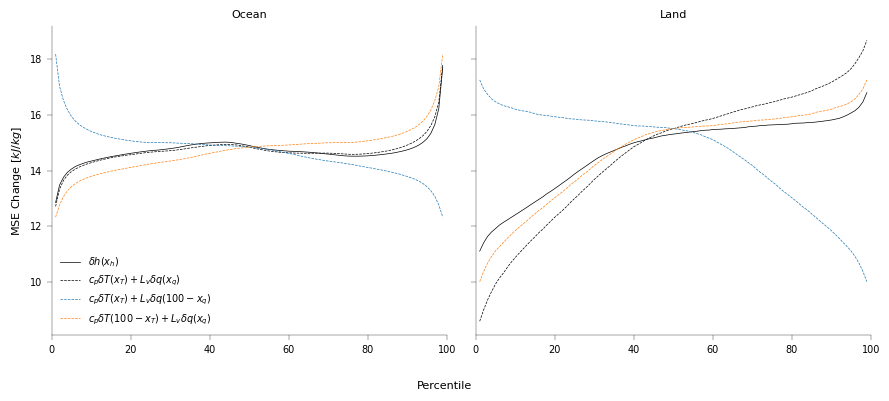

In [29]:
save_delta_mse_fig = False
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
for i, surf in enumerate(ds_all):
    ax[i].set_title(surf.capitalize())
    ax[i].plot(quant_plot, np.average((mse_quant2[surf][1]-mse_quant2[surf][0])[lat_use], axis=0, weights=lat_weights_use), 
               label = '$\delta h(x_h)$', color='k')
    ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0]) +
                                   L_v * (sphum_quant2[surf][1]-sphum_quant2[surf][0]))[lat_use], axis=0, weights=lat_weights_use)/1000,
            label='$c_p \delta T(x_T) + L_v \delta q(x_q)$', color='k', linestyle='--')
    ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0]) +
                               L_v * (sphum_quant2[surf][1]-sphum_quant2[surf][0])[:, ::-1])[lat_use], axis=0, weights=lat_weights_use)/1000,
        label='$c_p \delta T(x_T) + L_v \delta q(100-x_q)$', color=default_colors[0], linestyle='--')
    ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0])[:, ::-1] +
                           L_v * (sphum_quant2[surf][1]-sphum_quant2[surf][0]))[lat_use], axis=0, weights=lat_weights_use)/1000,
    label='$c_p \delta T(100-x_T) + L_v \delta q(x_q)$', color=default_colors[1], linestyle='--')
ax[0].legend()
fig.supxlabel('Percentile', fontsize=8)
ax[0].set_ylabel('MSE Change [$kJ/kg$]')
ax[0].set_xlim(0,100)
plt.tight_layout()
if save_fig or save_delta_mse_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_mse_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

### Theoretical Temperature Change
Below, we plot whether the aquaplanet theory can correctly predict the temperature change between adjacent simulations. The theory is not bad for ocean, but for land, it predicts suppressed warming of the hottest days, in direct contrast to what we see in the simulations.

In [11]:
temp_diff_theory = {surf: {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda']} for surf in ds_all}
for surf in ds_all:
    for method in temp_diff_theory['ocean']:
        for i in range(n_lat):
            temp_diff_theory[surf][method][i] = \
                get_delta_temp_quant_theory(temp_mean[surf][:, i], sphum_mean[surf][:, i], temp_quant2[surf][:, i], sphum_quant2[surf][:, i], p_surface,
                                            const_rh=True if method=='const_rh' else False,
                                            delta_mse_ratio=delta_mse_ratio[surf][i:i+1] if 'lambda' in method else None,
                                            taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')


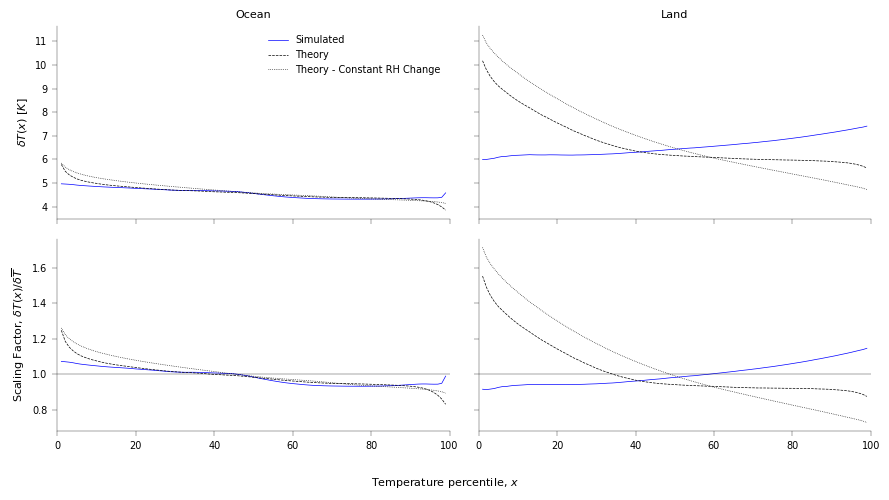

In [12]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude for theory
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too
if scaling_factor_av == 'mean':
    # Find temperature quantile if historical climate closest to mean
    av_quant_ind = {surf: [int(np.round(scipy.stats.percentileofscore(ds_all[surf][0].temp[i], float(ds_all[surf][0].temp[i].mean())))) 
                           for i in range(n_lat)] for surf in ds_all}
else:
    av_quant_ind = {surf: [50]*n_lat for surf in ds_all}
av_quant_ind = {surf: numpy_indexed.indices(quant_plot, np.asarray(av_quant_ind[surf])) for surf in ds_all}
av_quant_flat_ind = {surf: np.ravel_multi_index((np.arange(n_lat), av_quant_ind[surf]), temp_quant2[surf][0].shape) for surf in ds_all}
sf_denom = {surf: {key: temp_diff_theory[surf][key].flatten()[av_quant_flat_ind[surf]] for key in temp_diff_theory['ocean']} for surf in ds_all}
for surf in ds_all:
    if scaling_factor_av == 'mean':
        sf_denom[surf]['simulated'] = temp_mean[surf][1]-temp_mean[surf][0]
    else:
        sf_denom[surf]['simulated'] = (temp_quant2[surf][1]-temp_quant2[surf][0]).flatten()[av_quant_flat_ind[surf]]
    for key in sf_denom['ocean']:
        sf_denom[surf][key] = np.expand_dims(sf_denom[surf][key], axis=-1)
    if scaling_factor_av_type == 'simulated':
        for key in temp_diff_theory['ocean']:
            # Set all theoretical mean/median predictions to the simulated
            sf_denom[surf][key] = sf_denom[surf]['simulated'] 
    
    
save_theory_fig = False
fig, ax = plt.subplots(2,2, figsize=(9, 5), sharex=True, sharey='row')
for i, surf in enumerate(ds_all):
    ax[0, i].set_title(surf.capitalize())
    ax[0, i].plot(quant_plot, np.average((temp_quant2[surf][1]-temp_quant2[surf][0])[lat_use], axis=0, weights=lat_weights_use),
               label = 'Simulated', color='blue')
    ax[0, i].plot(quant_plot, np.average(temp_diff_theory[surf]['linear'][lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--',
               label='Theory')
    ax[0, i].plot(quant_plot, np.average(temp_diff_theory[surf]['const_rh'][lat_use], axis=0, weights=lat_weights_use), color='k',
               label='Theory - Constant RH Change', linestyle=':')
    ax[1, i].plot(quant_plot, np.average(((temp_quant2[surf][1]-temp_quant2[surf][0])/sf_denom[surf]['simulated'])[lat_use],
                                      axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
    ax[1, i].plot(quant_plot, np.average((temp_diff_theory[surf]['linear']/sf_denom[surf]['linear'])[lat_use], axis=0,
                                      weights=lat_weights_use), color='k', linestyle='--')
    ax[1, i].plot(quant_plot, np.average((temp_diff_theory[surf]['const_rh']/sf_denom[surf]['const_rh'])[lat_use], axis=0,
                                      weights=lat_weights_use), color='k', label='Theory - Constant RH Change', linestyle=':')
    ax[1, i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0, 0].legend()
fig.supxlabel('Temperature percentile, $x$', fontsize=8)
ax[0, 0].set_ylabel('$\delta T(x)$ [$K$]')
ax[1, 0].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
# label_subplots(fig, ax)
ax[0, 0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
# ax[1].set_ylim(0.89, 1.25)
plt.tight_layout()
if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/theory_{region.lower()}_{season}.pdf",dpi=high_dpi if publish_fig else low_dpi)

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T(x) = \gamma^T \delta \overline{T} + \gamma^{\Delta r} \delta (\overline{r}-r(x))$ and the dotted line is just $\gamma^T \delta \overline{T}$. The plots below show how these $\gamma$ factors vary with percentile.

Over land and ocean, $\gamma^T$ decreases as temperature percentile increases, explaining why theories over both land and ocean predict suppressed warming of the hottest days.

The equation for $\gamma^T$ is:
$$\gamma^T = \frac{c_p + L_v \bar{\alpha} \bar{q}}{c_p + L_v \alpha(x) q(x)}$$

$q(x)$ increases with $x$ for both land and ocean (shown in a few plots from now), as $x$ is specific humidity percentile, and by definition specific humidity increases as specific humidity percentile increases. This explains why $\gamma^T$ decreases as temperature percentile increases.

In [32]:
gamma_t = {surf: np.zeros((n_lat, n_quant)) for surf in ds_all}
gamma_rdiff = {surf: np.zeros((n_lat, n_quant)) for surf in ds_all}
for surf in ds_all:
    for i in range(n_lat):
        all_gamma = get_gamma(temp_mean[surf][:, i], sphum_mean[surf][:, i], temp_quant2[surf][:, i], sphum_quant2[surf][:, i], p_surface)
        gamma_t[surf][i] = all_gamma[0][0]
        gamma_rdiff[surf][i] = all_gamma[1][0]

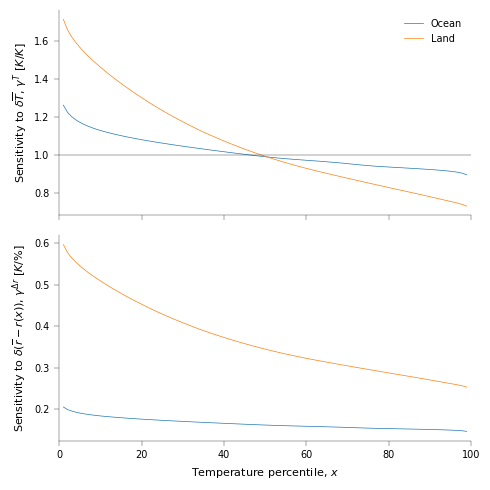

In [33]:
save_gamma_fig = False
fig, ax = plt.subplots(2,1, figsize=(5, 5), sharex=True)
for i, surf in enumerate(ds_all):
    ax[0].plot(quant_plot, np.average(gamma_t[surf][lat_use], axis=0, weights=lat_weights_use), color=default_colors[i], label=surf.capitalize())
    ax[1].plot(quant_plot, np.average(gamma_rdiff[surf][lat_use]/100, axis=0, weights=lat_weights_use), color=default_colors[i])
ax[0].legend()
ax[0].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$, $\gamma^T$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (\overline{r} - r(x))$, $\gamma^{\Delta r}$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
plt.tight_layout()
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}", dpi=high_dpi if publish_fig else low_dpi)

### Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.
There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the dotted line in the $\delta \chi/\delta \overline{\chi}$ plot. This should be equal to 1.
    In the plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown in the MSE Change plot. If this approximation was exact, we would expect the solid and dashed lines to match up exactly.
   In the plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

For ocean, approximation 1 is the most problematic as shown by the difference between the orange and green lines.
For land, approximation 2 is the most problematic, as shown by the difference between the green and blue lines.

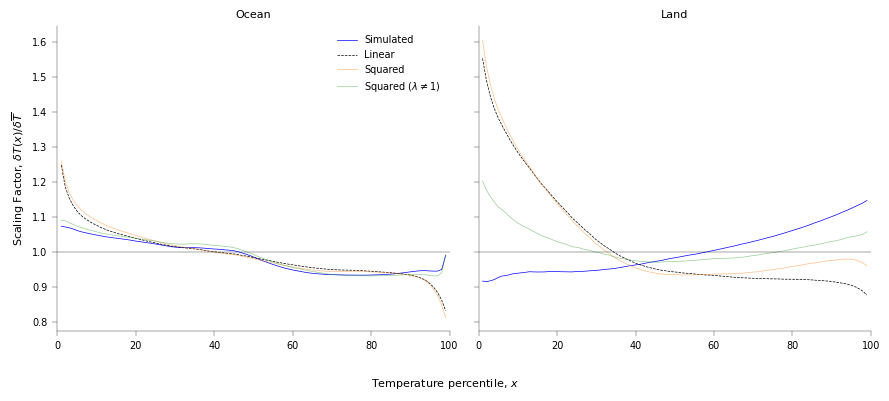

In [15]:
save_approx_fig = False
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
for i, surf in enumerate(ds_all):
    ax[i].set_title(surf.capitalize())
    ax[i].plot(quant_plot, np.average(((temp_quant2[surf][1]-temp_quant2[surf][0])/sf_denom[surf]['simulated'])[lat_use],
                                      axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
    ax[i].plot(quant_plot, np.average((temp_diff_theory[surf]['linear']/sf_denom[surf]['linear'])[lat_use], axis=0,
                                      weights=lat_weights_use), color='k', linestyle='--', label='Linear')
    ax[i].plot(quant_plot, np.average((temp_diff_theory[surf]['squared']/sf_denom[surf]['squared'])[lat_use], axis=0,
                                      weights=lat_weights_use), color=default_colors[1], alpha=0.5, label='Squared')
    ax[i].plot(quant_plot, np.average((temp_diff_theory[surf]['squared_lambda']/sf_denom[surf]['squared_lambda'])[lat_use],
                                      axis=0, weights=lat_weights_use), color=default_colors[2], alpha=0.5, label='Squared ($\lambda \\neq 1$)')
    ax[i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)

# ax.plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', linestyle='--', label='Theory $q^*(x)\delta r(x) = \overline{q^*}\delta r(x)$')
# ax.plot(quant_plot, np.average((temp_diff_theory['squared']/sf_denom['squared'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color=default_colors[1], alpha=0.5, 
#         label='Theory $q^*(x)\delta r(x) \\neq \overline{q^*}\delta r(x)$')

ax[0].legend()
fig.supxlabel('Temperature percentile, $x$', fontsize=8)
ax[0].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
plt.tight_layout()
if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_{region.lower()}_{season}.pdf", dpi=high_dpi if publish_fig else low_dpi)

### Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$.

Note, that this relative humidity is not a physical quantity. $r(x)$ is equal to the $x$ percentile of specific humidity, $q(x)$, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x))$.

In [16]:
r_mean2 = {surf: sphum_mean[surf] / sphum_sat(temp_mean[surf], p_surface) * 100 for surf in ds_all}
r_quant2 = {surf: sphum_quant2[surf] / sphum_sat(temp_quant2[surf], p_surface) * 100 for surf in ds_all}

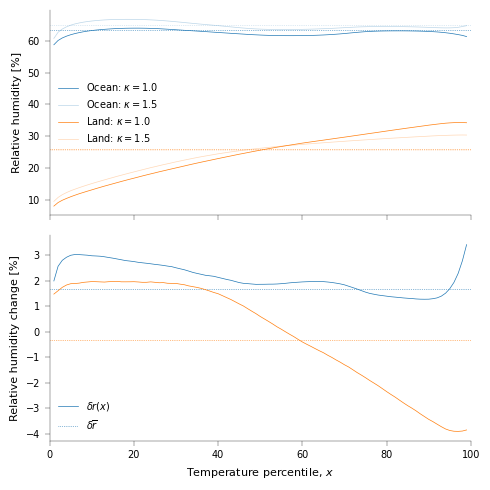

In [40]:
save_rh_fig = False
# choose which mean rh to plot - r_mean is mean over all RH values. r_mean2 is mean sphum divided by sphum_sat evaluated at mean temp.
# r_mean_use = r_mean
r_mean_use = r_mean2
alpha_seq_rh = [1, 0.3]
fig, ax = plt.subplots(2,1, figsize=(5, 5), sharex=True)
for j, surf in enumerate(ds_all):
    for i in range(n_exp):
        ax[0].plot(quant_plot, np.average(r_quant2[surf][i, lat_use], axis=0, weights=lat_weights_use),
                   color=default_colors[j], alpha=alpha_seq_rh[i], label='{}: $\kappa={:.1f}$'.format(surf.capitalize(), tau_lw[i]))
        ax[0].hlines(np.average(r_mean_use[surf][i, lat_use], weights=lat_weights_use), 0, 100, color=default_colors[j], linestyle=':',
                     alpha=alpha_seq_rh[i])
    ax[1].plot(quant_plot, np.average((r_quant2[surf][1]-r_quant2[surf][0])[lat_use], axis=0, weights=lat_weights_use), 
               color=default_colors[j], label='$\delta r(x)$' if j==0 else None)
    ax[1].hlines(np.average((r_mean_use[surf][1]-r_mean_use[surf][0])[lat_use], axis=0, weights=lat_weights_use), 0, 100, color=default_colors[j],  
                 linestyles=':', label='$\delta \overline{r}$' if j==0 else None)
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Relative humidity [%]')
ax[1].set_ylabel('Relative humidity change [%]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
# ax[0].set_ylim(5, 75)
# ax[0].set_ylim(61, 68.6)
# ax[1].set_ylim(1.1, 3.6)
plt.tight_layout()

if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}.pdf", dpi=high_dpi if publish_fig else low_dpi)

### Specific humidity
On the left below, I plot the specific humidity in the reference (colder) simulation as a function of percentile. The fact that this increases with x is the reason we see suppressed warming of the hottest days, for both land and ocean.

In hindsight, it is obvious that we would see this.

On the right, I plot specific humidity conditioned on temperature percentile, $x_T$. Now, we see the contrast between land and ocean, that we expect - over ocean (land), specific humidity increases (decreases) with temperature percentile. We need a theory which incorporates this.

In [18]:
# Specific humidity and MSE as a function of temperature percentile
sphum_quant3 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
mse_quant3 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
with tqdm(total=n_exp*n_quant*2*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in ds_all:
            mse = moist_static_energy(ds_all[surf][i].temp, ds_all[surf][i].sphum, ds_all[surf][i].height)
            for k in range(n_lat):
                if k not in lat_use:
                    continue
                for j, quant in enumerate(quant_plot):
                    # Take percentile to be surface moist static energy
                    use_ind = get_quant_ind(ds_all[surf][i].temp[k], quant, 0.5, 0.5)
                    sphum_quant3[surf][i, k, j] = ds_all[surf][i].sphum[k, use_ind].mean()
                    mse_quant3[surf][i, k, j] = mse[k, use_ind].mean()
                    pbar.update(1)

100%|██████████| 5544/5544 [00:34<00:00, 158.58it/s]


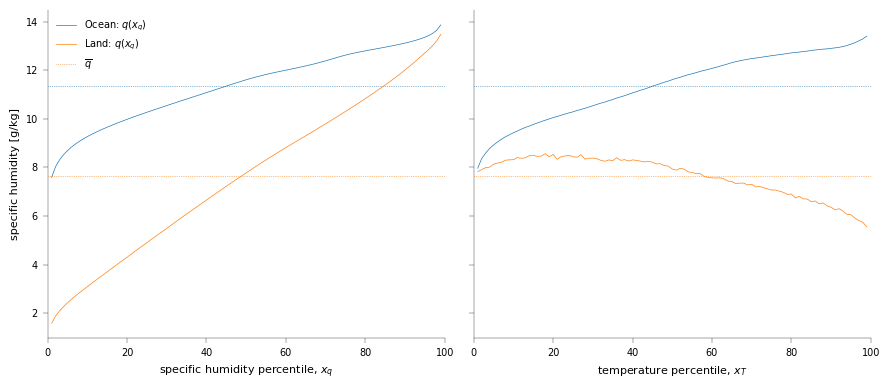

In [19]:
save_sphum_fig = False
include_mean = True
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
for i, surf in enumerate(ds_all):
    ax[0].plot(quant_plot, np.average(sphum_quant2[surf][0, lat_use], axis=0, weights=lat_weights_use)*1000, color=default_colors[i], 
               label=f'{surf.capitalize()}: $q(x_q)$')
    ax[1].plot(quant_plot, np.average(sphum_quant3[surf][0, lat_use], axis=0, weights=lat_weights_use)*1000, color=default_colors[i], 
           label=f'{surf.capitalize()}: $q(x_T)$')
    if include_mean:
        for j in range(len(ax)):
            ax[j].hlines(np.average(sphum_mean[surf][0, lat_use], weights=lat_weights_use)*1000, 0, 100, colors=default_colors[i], 
                         label='$\overline{q}$' if i==1 else None, linestyle=':', color=default_colors[i])
ax[0].set_xlim(0,100)
ax[0].set_ylabel('specific humidity [g/kg]')
ax[0].set_xlabel('specific humidity percentile, $x_q$')
ax[1].set_xlabel('temperature percentile, $x_T$')
ax[0].legend()
plt.tight_layout()
if save_sphum_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sphum_{region.lower()}_{season}.pdf", dpi=high_dpi if publish_fig else low_dpi)

## Doing everything as a function of temperature percentile
To incorporate the above contrast between specific humidity as a function of temperature percentile between land and ocean, below I go through a version of the theory where everything is conditioned on temperature percentile.

I.e. the starting point for the original theory is the approximation $\delta h(x_h) \approx \delta \overline{h}$, where $x_h$ is moist static energy percentile. The starting point for this version of the theory is $\delta h(x_T) \approx \delta \overline{h}$, where $h(x_T)$ is moist static energy conditioned on the temperature percentile.

### Percentile to Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, but for ocean and land separately.

This shows that the scaling, $\lambda(x_T) = \frac{\delta h(x_T)}{\delta \overline{h}}$, is very close to 1 for all percentiles, $x$ over ocean. Over land, the approximation is less valid, with $\lambda(x_T)$ decreasing with $x_T$.

Compared to the $x_h$ form of $\lambda$, the ocean plots are very similar, indicating that there is a good correspondence between $x_h$ and $x_T$ over ocean. 

Over land, the plots show the opposite trends, indicating that there is a poor correspondence between $x_h$ and $x_T$ over land.

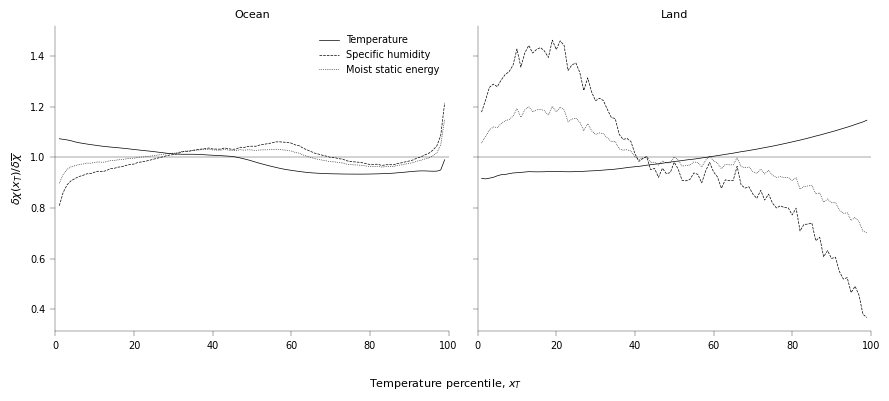

In [20]:
save_lambda3_fig = False
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
labels = ['Temperature','Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = {surf: [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean[surf], sphum_mean[surf], mse_mean[surf]]] for surf in ds_all}
linestyles = ['-', '--', ':']
for j, surf in enumerate(ds_all):
    ax[j].set_title(surf.capitalize())
    for i, var in enumerate([temp_quant2, sphum_quant3, mse_quant3]):
        var_ratio = (var[surf][1]-var[surf][0])/delta_var_mean[surf][i]
        ax[j].plot(quant_plot, np.average(var_ratio[lat_use], axis=0, weights=lat_weights_use), label=labels[i], color='k', linestyle=linestyles[i])
delta_mse3_ratio = {surf: (mse_quant3[surf][1]-mse_quant3[surf][0])/delta_var_mean[surf][-1] for surf in ds_all}
ax[0].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[1].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[0].legend()
fig.supxlabel('Temperature percentile, $x_T$', fontsize=8)
ax[0].set_ylabel('$\delta \chi(x_T)/\delta \overline{\chi}$')
# ax[0].set_ylim(0.85,1.15)
ax[0].set_xlim(0, 100)
plt.tight_layout()
if save_fig or save_lambda3_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda3_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

### Equating Percentiles Approximation 

This plot investigates whether $\delta h(x_T) \approx c_p \delta T(x_T) + L_v \delta q(x_T)$ is valid. 

The equality between the solid black and thick grey lines for ocean and land are perfect, indicating this equation is not problematic.

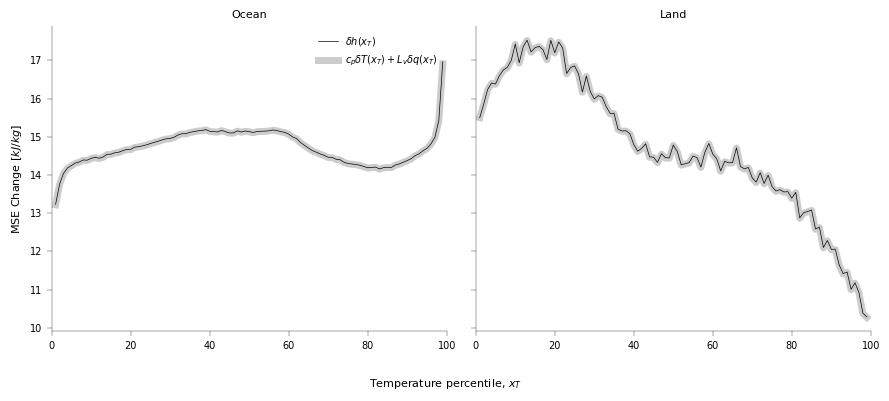

In [21]:
save_delta_mse3_fig = False
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
for i, surf in enumerate(ds_all):
    ax[i].set_title(surf.capitalize())
    ax[i].plot(quant_plot, np.average((mse_quant3[surf][1]-mse_quant3[surf][0])[lat_use], axis=0, weights=lat_weights_use), 
               label = '$\delta h(x_T)$', color='k')
    ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0]) +
                                   L_v * (sphum_quant3[surf][1]-sphum_quant3[surf][0]))[lat_use], axis=0, weights=lat_weights_use)/1000,
            label='$c_p \delta T(x_T) + L_v \delta q(x_T)$', color='k', lw=5, alpha=0.2)
    # ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0]) +
    #                            L_v * (sphum_quant3[surf][1]-sphum_quant3[surf][0])[:, ::-1])[lat_use], axis=0, weights=lat_weights_use)/1000,
    #     label='$c_p \delta T(x_T) + L_v \delta q(100-x_T)$', color=default_colors[0], linestyle='--')
    # ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0])[:, ::-1] +
    #                        L_v * (sphum_quant3[surf][1]-sphum_quant3[surf][0]))[lat_use], axis=0, weights=lat_weights_use)/1000,
    # label='$c_p \delta T(100-x) + L_v \delta q(x)$', color=default_colors[1], linestyle='--')
    # ax[i].plot(quant_plot, np.average((c_p * (temp_quant2[surf][1]-temp_quant2[surf][0]) +
    #                            L_v * (sphum_quant3[surf][1]-sphum_quant3[surf][0]))[lat_use, ::-1], axis=0, weights=lat_weights_use)/1000,
    #     label='$c_p \delta T(100-x_T) + L_v \delta q(100-x_T)$', color=default_colors[2], linestyle='--')
ax[0].legend()
fig.supxlabel('Temperature percentile, $x_T$', fontsize=8)
ax[0].set_ylabel('MSE Change [$kJ/kg$]')
ax[0].set_xlim(0,100)
plt.tight_layout()
if save_fig or save_delta_mse3_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_mse3_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

### Theoretical Temperature Change
Below, we plot whether the aquaplanet theory based on temperature percentiles can correctly predict the temperature change between adjacent simulations.

For ocean, the theory is almost identical to the original MSE percentile based theory.

For land, this version of the theory is a vast improvement, with the amplified warming of hot days now predicted. Interestingly, the constant relative humidity version of the theory seems to perform better.

In [22]:
temp_diff_theory3 = {surf: {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda']} for surf in ds_all}
for surf in ds_all:
    for method in temp_diff_theory3['ocean']:
        for i in range(n_lat):
            if i not in lat_use:
                continue
            temp_diff_theory3[surf][method][i] = \
                get_delta_temp_quant_theory(temp_mean[surf][:, i], sphum_mean[surf][:, i], temp_quant2[surf][:, i], sphum_quant3[surf][:, i], p_surface,
                                            const_rh=True if method=='const_rh' else False,
                                            delta_mse_ratio=delta_mse3_ratio[surf][i:i+1] if 'lambda' in method else None,
                                            taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')

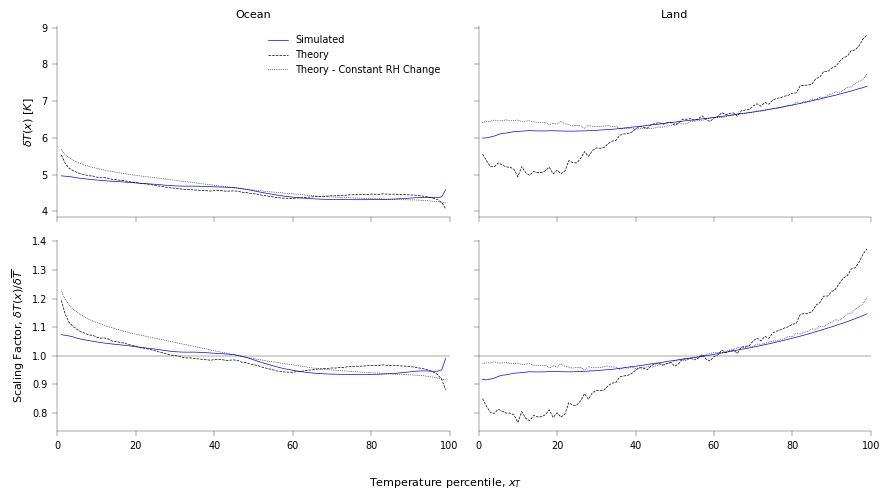

In [23]:
if scaling_factor_av == 'mean':
    # Find temperature quantile if historical climate closest to mean
    av_quant_ind = {surf: [int(np.round(scipy.stats.percentileofscore(ds_all[surf][0].temp[i], float(ds_all[surf][0].temp[i].mean())))) 
                           for i in range(n_lat)] for surf in ds_all}
else:
    av_quant_ind = {surf: [50]*n_lat for surf in ds_all}
av_quant_ind = {surf: numpy_indexed.indices(quant_plot, np.asarray(av_quant_ind[surf])) for surf in ds_all}
av_quant_flat_ind = {surf: np.ravel_multi_index((np.arange(n_lat), av_quant_ind[surf]), temp_quant2[surf][0].shape) for surf in ds_all}
sf_denom3 = {surf: {key: temp_diff_theory3[surf][key].flatten()[av_quant_flat_ind[surf]] for key in temp_diff_theory3['ocean']} for surf in ds_all}
for surf in ds_all:
    if scaling_factor_av == 'mean':
        sf_denom3[surf]['simulated'] = temp_mean[surf][1]-temp_mean[surf][0]
    else:
        sf_denom3[surf]['simulated'] = (temp_quant2[surf][1]-temp_quant2[surf][0]).flatten()[av_quant_flat_ind[surf]]
    for key in sf_denom['ocean']:
        sf_denom3[surf][key] = np.expand_dims(sf_denom3[surf][key], axis=-1)
    if scaling_factor_av_type == 'simulated':
        for key in temp_diff_theory3['ocean']:
            # Set all theoretical mean/median predictions to the simulated
            sf_denom3[surf][key] = sf_denom3[surf]['simulated'] 
    
    
save_theory3_fig = False
fig, ax = plt.subplots(2,2, figsize=(9, 5), sharex=True, sharey='row')
for i, surf in enumerate(ds_all):
    ax[0, i].set_title(surf.capitalize())
    ax[0, i].plot(quant_plot, np.average((temp_quant2[surf][1]-temp_quant2[surf][0])[lat_use], axis=0, weights=lat_weights_use),
               label = 'Simulated', color='blue')
    ax[0, i].plot(quant_plot, np.average(temp_diff_theory3[surf]['linear'][lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--',
               label='Theory')
    ax[0, i].plot(quant_plot, np.average(temp_diff_theory3[surf]['const_rh'][lat_use], axis=0, weights=lat_weights_use), color='k',
               label='Theory - Constant RH Change', linestyle=':')
    ax[1, i].plot(quant_plot, np.average(((temp_quant2[surf][1]-temp_quant2[surf][0])/sf_denom3[surf]['simulated'])[lat_use],
                                      axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
    ax[1, i].plot(quant_plot, np.average((temp_diff_theory3[surf]['linear']/sf_denom3[surf]['linear'])[lat_use], axis=0,
                                      weights=lat_weights_use), color='k', linestyle='--')
    ax[1, i].plot(quant_plot, np.average((temp_diff_theory3[surf]['const_rh']/sf_denom3[surf]['const_rh'])[lat_use], axis=0,
                                      weights=lat_weights_use), color='k', label='Theory - Constant RH Change', linestyle=':')
    ax[1, i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0, 0].legend()
fig.supxlabel('Temperature percentile, $x_T$', fontsize=8)
ax[0, 0].set_ylabel('$\delta T(x)$ [$K$]')
ax[1, 0].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
# label_subplots(fig, ax)
ax[0, 0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
# ax[1].set_ylim(0.89, 1.25)
plt.tight_layout()
if save_fig or save_theory3_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/theory3_{region.lower()}_{season}.pdf",dpi=high_dpi if publish_fig else low_dpi)

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T(x_T) = \gamma^T \delta \overline{T} + \gamma^{\Delta r} \delta (\overline{r}-r(x_T))$ and the dotted line is just $\gamma^T \delta \overline{T}$. The plots below show how these $\gamma$ factors vary with percentile.

In this version of the theory, $\gamma^T$ now behaves differently as a function of temperature percentile over land and ocean.

The equation for $\gamma^T$ is:
$$\gamma^T = \frac{c_p + L_v \bar{\alpha} \bar{q}}{c_p + L_v \alpha(x_T) q(x_T)}$$

$q(x_T)$ increases (decreases) with $x_T$ over ocean (land), as shown in the earlier right specific humidity plot. This explains why $\gamma^T$ decreases (increases) as temperature percentile increases over ocean (land).

In [35]:
gamma3_t = {surf: np.zeros((n_lat, n_quant)) for surf in ds_all}
gamma3_rdiff = {surf: np.zeros((n_lat, n_quant)) for surf in ds_all}
for surf in ds_all:
    for i in range(n_lat):
        all_gamma = get_gamma(temp_mean[surf][:, i], sphum_mean[surf][:, i], temp_quant2[surf][:, i],
                              sphum_quant3[surf][:, i], p_surface)
        gamma3_t[surf][i] = all_gamma[0][0]
        gamma3_rdiff[surf][i] = all_gamma[1][0]

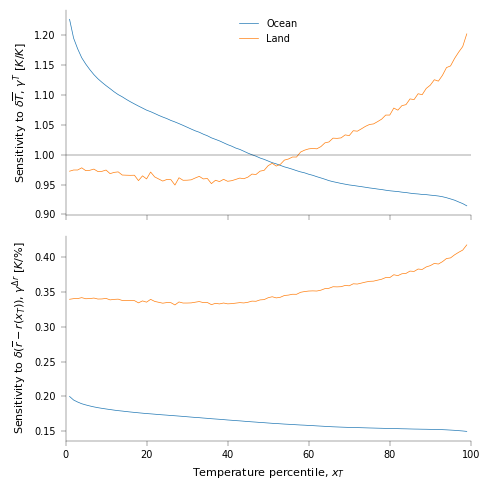

In [36]:
save_gamma3_fig = False
fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
for i, surf in enumerate(ds_all):
    ax[0].plot(quant_plot, np.average(gamma3_t[surf][lat_use], axis=0, weights=lat_weights_use), color=default_colors[i],
               label=surf.capitalize())
    ax[1].plot(quant_plot, np.average(gamma3_rdiff[surf][lat_use] / 100, axis=0, weights=lat_weights_use),
               color=default_colors[i])
ax[0].legend()
ax[0].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$, $\gamma^T$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (\overline{r} - r(x_T))$, $\gamma^{\Delta r}$ [$K/$%]')
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('Temperature percentile, $x_T$')
plt.tight_layout()
if save_fig or save_gamma3_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma3_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

### Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.

For both ocean and land, approximation 1 is the most problematic as shown by the difference between the orange and green lines. The size of the difference is much larger over land though.

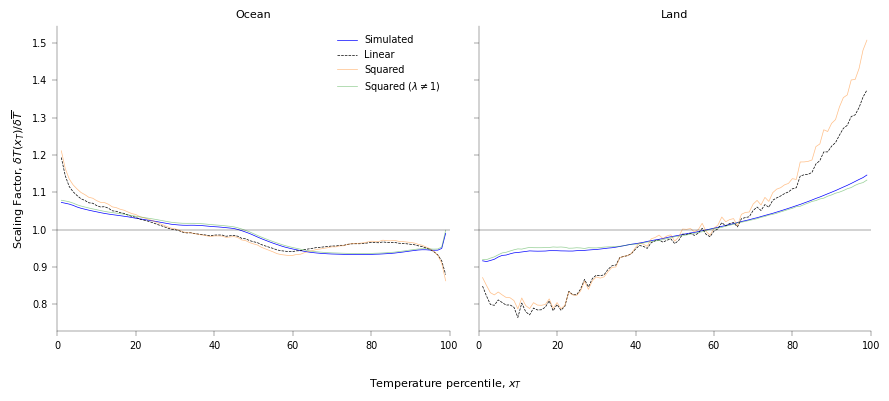

In [24]:
save_approx3_fig = False
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
for i, surf in enumerate(ds_all):
    ax[i].set_title(surf.capitalize())
    ax[i].plot(quant_plot, np.average(((temp_quant2[surf][1]-temp_quant2[surf][0])/sf_denom3[surf]['simulated'])[lat_use],
                                      axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
    ax[i].plot(quant_plot, np.average((temp_diff_theory3[surf]['linear']/sf_denom3[surf]['linear'])[lat_use], axis=0,
                                      weights=lat_weights_use), color='k', linestyle='--', label='Linear')
    ax[i].plot(quant_plot, np.average((temp_diff_theory3[surf]['squared']/sf_denom3[surf]['squared'])[lat_use], axis=0,
                                      weights=lat_weights_use), color=default_colors[1], alpha=0.5, label='Squared')
    ax[i].plot(quant_plot, np.average((temp_diff_theory3[surf]['squared_lambda']/sf_denom3[surf]['squared_lambda'])[lat_use],
                                      axis=0, weights=lat_weights_use), color=default_colors[2], alpha=0.5, label='Squared ($\lambda \\neq 1$)')
    ax[i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)

# ax.plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color='k', linestyle='--', label='Theory $q^*(x)\delta r(x) = \overline{q^*}\delta r(x)$')
# ax.plot(quant_plot, np.average((temp_diff_theory['squared']/sf_denom['squared'])[lat_use], axis=0,
#                                   weights=lat_weights_use), color=default_colors[1], alpha=0.5, 
#         label='Theory $q^*(x)\delta r(x) \\neq \overline{q^*}\delta r(x)$')

ax[0].legend()
fig.supxlabel('Temperature percentile, $x_T$', fontsize=8)
ax[0].set_ylabel('Scaling Factor, $\delta T(x_T) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
plt.tight_layout()
if save_fig or save_approx3_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx3_{region.lower()}_{season}.pdf", dpi=high_dpi if publish_fig else low_dpi)

### Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$.

Note, that this relative humidity is different to the previous version in the MSE based version of the theory. $r(x_T)$ is equal to the specific humidity conditioned on the $x_T$ percentile of temperature, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x_T))$.

For ocean, the two relative humidity definitions are very similar.

For land, the relative humidity change is pretty similar, but the trend is for relative humidity to decrease rather than increase with temperature percentile

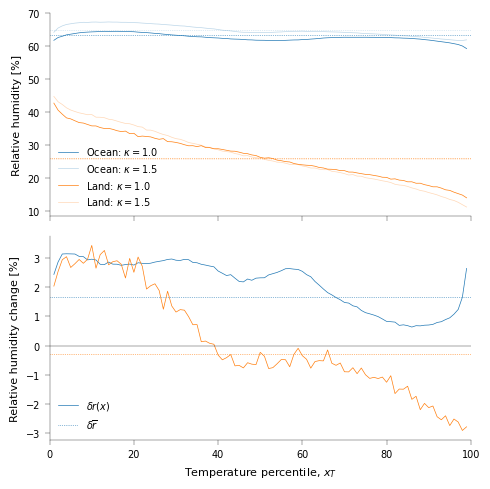

In [43]:
r_quant3 = {surf: sphum_quant3[surf] / sphum_sat(temp_quant2[surf], p_surface) * 100 for surf in ds_all}
save_rh3_fig = False
# choose which mean rh to plot - r_mean is mean over all RH values. r_mean2 is mean sphum divided by sphum_sat evaluated at mean temp.
# r_mean_use = r_mean
r_mean_use = r_mean2
fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
for j, surf in enumerate(ds_all):
    for i in range(n_exp):
        ax[0].plot(quant_plot, np.average(r_quant3[surf][i, lat_use], axis=0, weights=lat_weights_use),
                   color=default_colors[j], alpha=alpha_seq_rh[i],
                   label='{}: $\kappa={:.1f}$'.format(surf.capitalize(), tau_lw[i]))
        ax[0].hlines(np.average(r_mean_use[surf][i, lat_use], weights=lat_weights_use), 0, 100, color=default_colors[j],
                     linestyle=':', alpha=alpha_seq_rh[i])
    ax[1].plot(quant_plot,
               np.average((r_quant3[surf][1] - r_quant3[surf][0])[lat_use], axis=0, weights=lat_weights_use),
               color=default_colors[j], label='$\delta r(x)$' if j == 0 else None)
    ax[1].hlines(np.average((r_mean_use[surf][1] - r_mean_use[surf][0])[lat_use], axis=0, weights=lat_weights_use), 0,
                 100, color=default_colors[j],
                 linestyles=':', label='$\delta \overline{r}$' if j == 0 else None)
ax[-1].set_xlabel('Temperature percentile, $x_T$')
ax[0].set_ylabel('Relative humidity [%]')
ax[1].set_ylabel('Relative humidity change [%]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[1].hlines(0, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_xlim(0, 100)
# ax[0].set_ylim(5, 75)
# ax[0].set_ylim(61, 68.6)
# ax[1].set_ylim(1.1, 3.6)
plt.tight_layout()

if save_fig or save_rh3_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh3_{region.lower()}_{season}.pdf",
                dpi=high_dpi if publish_fig else low_dpi)